In [53]:
import numpy as np
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
import scipy.optimize as opt

#Requerimiento
Q_litros=2.5 #[L/min]
Q_gpm = Q_litros*0.264172/1 #[gal/min]
print("Q [gpm]",Q_gpm)
Q = Q_gpm*231/(60*12**3) #[ft3/s]
print("Q [ft3/s]",Q)
#H = 50 #[ft]

H_metros=3.5 #[m]
H=H_metros*3.28084 #[ft]

#Motor síncrono

#Polos = 4
#fhz = 60 #[hz]
#n = (120*fhz/Polos)*np.pi/30 #[Rad/s]
#print("n [rad/s]",n)
#RPM = (120*fhz/Polos) #[RPM]

#Motor BLDC
RPM=10000
n=RPM*np.pi/30 #[Rad/s]
print("n [rad/s]",n)

#Calcula Ns

Ns = n*Q**(1/2)/((32.2*H)**(3/4))
print("Ns",Ns)
#Cordier
if Ns > 0.85:
    Ds = (8.26/Ns)**0.517
else:
    Ds = (2.5/Ns)**1.092
print("Ds",Ds)    


#Diámetro en in
D = Ds*12*Q**0.5/((32.2*H)**(0.25))
print("Diámetro del rotor en in",D)

#Estimar el ojo mediante Wright
d = 12*D*1.53*(Q/(n*D**3))**(1/3)
print("d ojo [in]",d)

#Asumiendo b1 igual a d/4
b1 = d/4 #[in]
print("b1 [in]",b1)

#Se plantea el triángulo de velocidades a la entrada
U1 = d*n/(2*12) #[ft/s]
print("U1 [ft/s]",U1)
V1 = Q/(np.pi*d*b1/12**2) #[ft/s]
print("V1 [ft/s]",V1)
W1 = np.sqrt(U1**2+V1**2) #[ft/s]
print("W1 [ft/s]",W1)
beta1 = np.arctan(V1/U1)*180/np.pi #[grados]
print("Beta 1 [º]",beta1)
alfa1 = 90 #[grados]

#Triángulo de velocidades a la salida
U2 = D*n/(12*2) #[ft/s]
print("U2 [ft/s]",U2)
V2_r = V1 #[ft/s]
#Se determina b2 a partir del Q, que es el mismo de la entrada
b2 = 12*Q/(np.pi*(D/12)*V2_r)
print("b2 [in]",b2)

#Se estima la eficiencia para usar la ecuación de euler
Nsd = RPM*np.sqrt(Q_gpm)/(H**0.75)
print("Nsd",Nsd)

Q [gpm] 0.6604300000000001
Q [ft3/s] 0.0014714441550925928
n [rad/s] 1047.1975511965977
Ns 0.476396744052339
Ds 6.1123550976037775
Diámetro del rotor en in 0.6416297213720575
d ojo [in] 0.20564164326071085
b1 [in] 0.051410410815177714
U1 [ft/s] 8.97280938527753
V1 [ft/s] 6.379611962387603
W1 [ft/s] 11.009575698234856
Beta 1 [º] 35.41259148838002
U2 [ft/s] 27.996378041490583
b2 [in] 0.016476981986018352
Nsd 1302.787475394821


Se usa el diagrama de eficiencia vs Nsd para estimar eta
![alt text](image.png)

In [54]:
eta = 0.65 #[Eficiencia de la bomba a partir del diagrama (Nsd y gpm)]

#Número adimensional de cabeza psi

Psi = 2*32.2*H/(eta*U2**2)
print("Psi",Psi)


Psi 1.4515162686356213


A partir del número adimensional de cabeza se determina B (lado de la garganta suponiendola cuadrada)
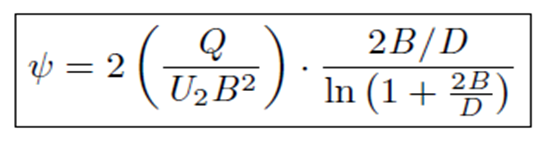

In [55]:
from scipy.optimize import fsolve

f = lambda x: Psi - 2*(Q/(U2*(x/12)**2))*(2*x/D)/np.log(1+2*x/D)
B = fsolve(f, 1e-1) #Lado de la garganta suponiendo que es cuadrada
print("B",B)
A_gar = B**2 #[in^2]
print("Área garganta",A_gar)
phi=Q/(U2*(B/12)**2)
print("phi",phi)


B [0.11013812]
Área garganta [0.0121304]
phi [0.62392034]


Se determina el factor Y
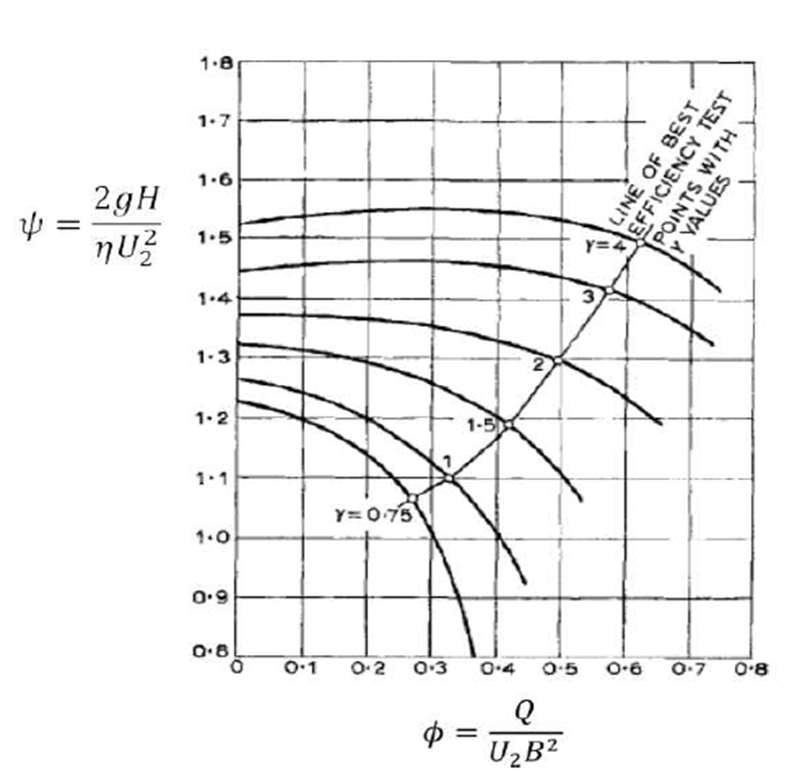

In [60]:
Y = 2.8

V2_th_K = 32.2*H/(U2*eta)
print("V2 tangencial con desilazamiento",V2_th_K)
V2 = np.sqrt(V2_r**2+V2_th_K**2)
print("V2 con deslizamiento",V2)

beta2 = np.atan(Y*A_gar/(np.pi*b2*D))*180/np.pi
print("beta 2 geometrica en grados",beta2)

beta2_k = np.atan(V2_r/(U2-V2_th_K))*180/np.pi
print("beta 2 real del flujo",beta2_k)

V2_th = U2 - V2_r/np.tan(beta2*np.pi/180)
print("V2 tangencial sin deslizamiento [ft/s]",V2_th)

alfa2 = np.atan(V2_r/V2_th_K)*180/np.pi
print("Alfa 2 en grados",alfa2)

dV_th = V2_th-V2_th_K
print("Diferencia entre velocidades tangenciales con y sin deslizamiento",dV_th)

W2 = V2_r/np.sin(beta2*np.pi/180)
print("W2 [ft/s]",W2)

K = 1 - dV_th/U2
print("K",K)

Rh=1-(V2**2-V1**2)/(2*(U2*V2_th))
print("Rh",Rh)

#Curva de la voluta
C=V2_th*D/(2*12) #[ft2/s]
tau=2*np.pi*C*B/(Q) #[s]

V2 tangencial con desilazamiento 20.31859909504833
V2 con deslizamiento 21.296594046371307
beta 2 geometrica en grados [45.64120454]
beta 2 real del flujo 39.72383411371768
V2 tangencial sin deslizamiento [ft/s] [21.75798175]
Alfa 2 en grados 17.43118961263391
Diferencia entre velocidades tangenciales con y sin deslizamiento [1.43938265]
W2 [ft/s] [8.92283795]
K [0.94858683]
Rh [0.66112692]


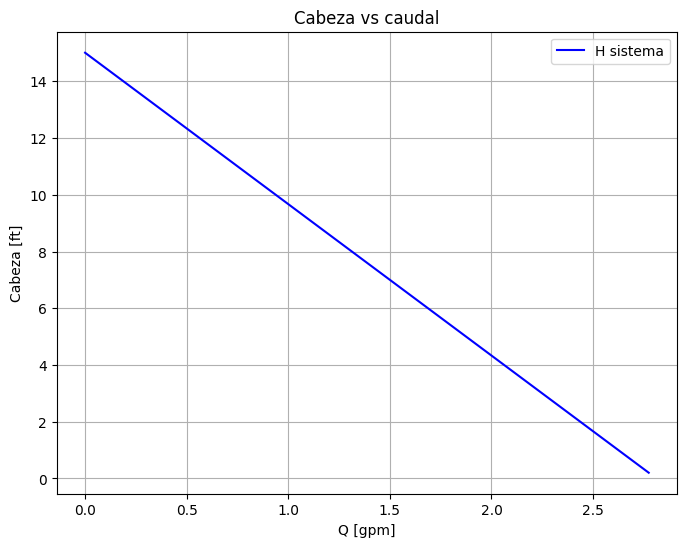

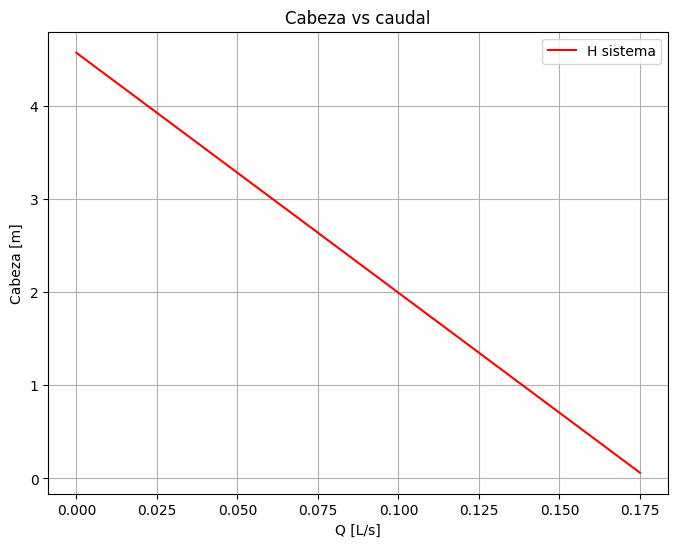

[0.         0.04374997 0.08749994 0.13124991 0.17499988]
[4.57460101 3.44626995 2.31793889 1.18960784 0.06127678]


In [57]:

Q_graf_gpm = np.linspace(0,Q_gpm*4.2,5)
Q_graf_ft3 = Q_graf_gpm*231/(60*12**3)
H_graf = (eta*U2**2)/(2*32.2)*(2*K - 2*Q_graf_ft3/(np.pi*D*b2*U2*np.tan(beta2*np.pi/180)/144))

Q_graf_lt_s = Q_graf_gpm*3.78541/60
H_graf_m = H_graf/3.28084


plt.figure(figsize=(8,6))
plt.plot(Q_graf_gpm, H_graf, 'b-', label="H sistema")


plt.xlabel("Q [gpm]")
plt.ylabel("Cabeza [ft]")
plt.title("Cabeza vs caudal")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(Q_graf_lt_s, H_graf_m, 'r-', label="H sistema")
plt.xlabel("Q [L/s]")
plt.ylabel("Cabeza [m]")
plt.title("Cabeza vs caudal")
plt.legend()
plt.grid(True)
plt.show()

print(Q_graf_lt_s)
print(H_graf_m)

Text(0, 0.5, 'Y [in]')

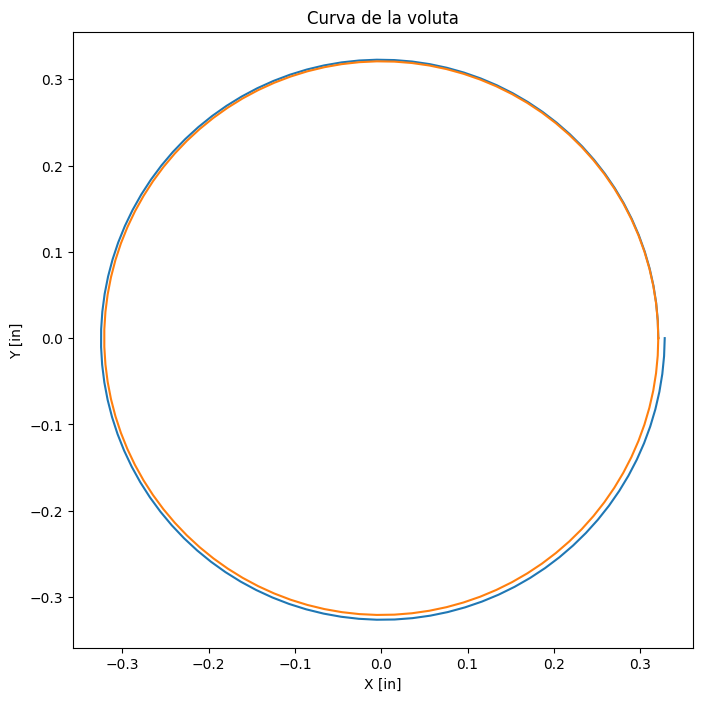

In [64]:
theta=np.linspace(0,2*np.pi,100)
r_exp=D/(2*12)*np.exp(theta/tau)

plt.figure(figsize=(8,8))
plt.plot(12*r_exp*np.cos(theta), 12*r_exp*np.sin(theta))
plt.plot(D*np.cos(theta)/2, D*np.sin(theta)/2)
plt.title("Curva de la voluta")
plt.xlabel("X [in]")
plt.ylabel("Y [in]")